In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Bernoulli Bandit

`Bandit`有$K$个动作，每次去选择一个动作就能够以概率$0 \le \theta_k \le 1$获取`1`的奖励。智能体的目标是在T次动作的选择过程中使得遗憾值最小:

$$\rho = T\theta^* - \sum_{t=1}^T r_t$$

其中$\theta^* = \max_k\{\theta_k\}$。


- https://arxiv.org/pdf/1507.08025.pdf

In [2]:

class BernoulliBandit:
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)
        
    @property
    def action_count(self):
        return len(self._probs)
    
    def pull(self, action):
        if np.random.random() > self._probs[action]:
            return 0.0
        return 1.0
    
    def optimal_reward(self):
        """ Used for regret calculation
        """
        return np.max(self._probs)
    
    def step(self):
        """ Used in nonstationary version
        """
        pass
    
    def reset(self):
        """ Used in nonstationary version
        """

## 定义一个基类智能体


In [3]:
from abc import ABCMeta, abstractmethod

class AbstractAgent(metaclass=ABCMeta):   
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0
    
    @abstractmethod
    def get_action(self):
        """
        Get current best action
        :rtype: int
        """
        pass
    
    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1
    
    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):    
    def get_action(self):
        return np.random.randint(0, len(self._successes))

### Epsilon-greedy智能体

for $t=1,2, \ldots$ do

for $k=1, \ldots, K$ do

$$\hat{\theta}_{k} \leftarrow \alpha_{k} /\left(\alpha_{k}+\beta_{k}\right)$$

end for

$x_{t} \leftarrow \operatorname{argmax}_{k} \hat{\theta}$ with probability $1-\epsilon$ or random action with probability $\epsilon$

for $t=1,2, \ldots$ do

for $k=1, \ldots, K$ do

$$
\hat{\theta}_{k} \leftarrow \alpha_{k} /\left(\alpha_{k}+\beta_{k}\right)
$$

end for

end for

Apply $x_{t}$ and observe $r_{t}$

$\left(\alpha_{x_{t}}, \beta_{x_{t}}\right) \leftarrow\left(\alpha_{x_{t}}, \beta_{x_{t}}\right)+\left(r_{t}, 1-r_{t}\right)$

end for

In [4]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon = 0.01):
        self._epsilon = epsilon

    def get_action(self):
        
        prob = np.random.rand()
        
        if prob > self._epsilon:
            return np.argmax(self._successes / (self._successes + self._failures) )
        else:
            return np.random.choice(len(self._successes))
        
    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon) 

### UCB Agent

`Epsilon`贪心策略对行为没有偏好。最好是在不确定或有可能达到最优的行动中进行选择。人们可以为同时代表不确定性和不确定性的每一个动作提出索引的想法。一种有效的方法是使用`UCB1`算法：

for $t=1,2, \ldots$ do

for $k=1, \ldots, K$ do
$$
w_{k} \leftarrow \alpha_{k} /\left(\alpha_{k}+\beta_{k}\right)+\sqrt{2 \log t /\left(\alpha_{k}+\beta_{k}\right)}
$$
end for
$$
x_{t} \leftarrow \operatorname{argmax}_{k} w
$$
    
Apply $x_{t}$ and observe $r_{t}$
$$
\left(\alpha_{x_{t}}, \beta_{x_{t}}\right) \leftarrow\left(\alpha_{x_{t}}, \beta_{x_{t}}\right)+\left(r_{t}, 1-r_{t}\right)
$$
end for

In [5]:
class UCBAgent(AbstractAgent):
    def get_action(self):
        
        weights = np.zeros_like(self._successes)
        
        weights = (self._successes/(self._successes + self._failures)) + np.sqrt(2 * np.log(self._total_pulls) / (self._successes + self._failures) )
                
        return np.argmax(weights)
    
    @property
    def name(self):
        return self.__class__.__name__

### Thompson sampling

`UCB1`算法没有考虑奖励的实际分配。如果我们知道分布，我们可以通过使用汤普森抽样做得更好：

for $t=1,2, \ldots$ do

for $k=1, \ldots, K$ do

$$ \text{Sample}\ \ \hat{\theta}_{k} \sim \operatorname{beta}\left(\alpha_{k}, \beta_{k}\right)$$

end for

$x_{t} \leftarrow \operatorname{argmax}_{k} \hat{\theta}$

Apply $x_{t}$ and observe $r_{t}$

$\left(\alpha_{x_{t}}, \beta_{x_{t}}\right) \leftarrow\left(\alpha_{x_{t}}, \beta_{x_{t}}\right)+\left(r_{t}, 1-r_{t}\right)$

end for

更多关于Tompson Sampling: https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

In [6]:
class ThompsonSamplingAgent(AbstractAgent):
    def get_action(self):
        # YOUR CODE HERE
        eps = 1e-12
        
        weights = np.zeros_like(self._successes)
        
        weights = np.random.beta(self._successes + eps, self._failures + eps)
        
        return np.argmax(weights)
    
    @property
    def name(self):
        return self.__class__.__name__

In [7]:
def plot_regret(env, agents, n_steps=5000, n_trials=50):
    scores = {
        agent.name : [0.0 for step in range(n_steps)] for agent in agents
    }

    for trial in range(n_trials):
        env.reset()
        
        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()
            
            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward
                
            env.step()  # change bandit's state if it is unstationary

    plt.figure(figsize=(17, 8))
    for agent in agents:
        plt.plot(np.cumsum(scores[agent.name]) / n_trials)

    plt.legend([agent.name for agent in agents])
    
    plt.ylabel("regret")
    plt.xlabel("steps")
    
    plt.show()

/var/folders/x9/xgj8n5xd2bb0cv55w7c72bn40000gn/T/ipykernel_31594/884386608.py:10: RuntimeWarning: invalid value encountered in true_divide
  return np.argmax(self._successes / (self._successes + self._failures) )
/var/folders/x9/xgj8n5xd2bb0cv55w7c72bn40000gn/T/ipykernel_31594/2254239578.py:6: RuntimeWarning: invalid value encountered in true_divide
  weights = (self._successes/(self._successes + self._failures)) + np.sqrt(2 * np.log(self._total_pulls) / (self._successes + self._failures) )
/var/folders/x9/xgj8n5xd2bb0cv55w7c72bn40000gn/T/ipykernel_31594/2254239578.py:6: RuntimeWarning: divide by zero encountered in log
  weights = (self._successes/(self._successes + self._failures)) + np.sqrt(2 * np.log(self._total_pulls) / (self._successes + self._failures) )
/var/folders/x9/xgj8n5xd2bb0cv55w7c72bn40000gn/T/ipykernel_31594/2254239578.py:6: RuntimeWarning: invalid value encountered in sqrt
  weights = (self._successes/(self._successes + self._failures)) + np.sqrt(2 * np.log(self._tota

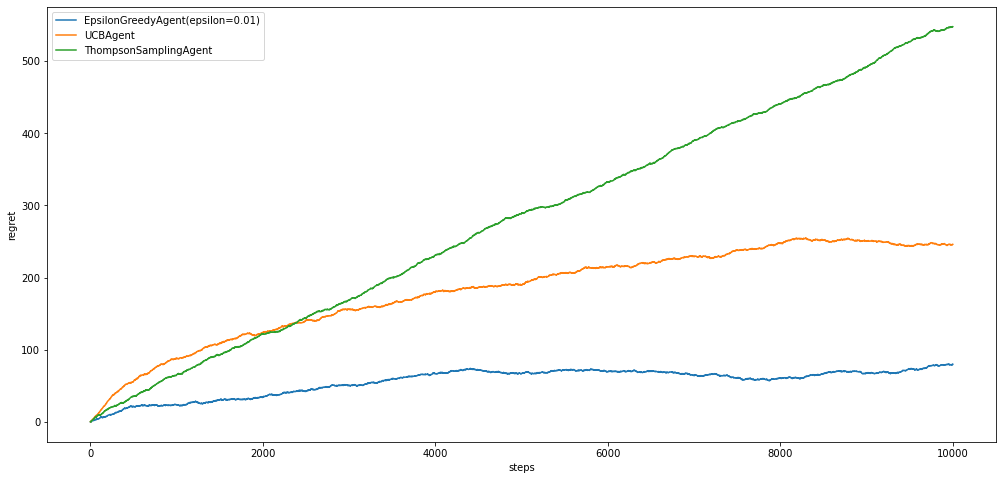

In [8]:
# Uncomment agents
agents = [
     EpsilonGreedyAgent(),
     UCBAgent(),
     ThompsonSamplingAgent()
]

plot_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)

### Nonstationary Bernoulli bandit

如果bandit的选择动作的概率会变呢?

In [9]:
class DriftingBandit(BernoulliBandit):
    def __init__(self, n_actions=5, gamma=0.01):
        """
        Idea from https://github.com/iosband/ts_tutorial
        """
        super().__init__(n_actions)
        
        self._gamma = gamma
        
        self._successes = None
        self._failures = None
        self._steps = 0
        
        self.reset()
        
    def reset(self):
        self._successes = np.zeros(self.action_count) + 1.0
        self._failures = np.zeros(self.action_count) + 1.0
        self._steps = 0
    
    def step(self):
        action = np.random.randint(self.action_count)
        reward = self.pull(action)
        self._step(action, reward)
        
    def _step(self, action, reward): 
        self._successes = self._successes * (1 - self._gamma) + self._gamma
        self._failures = self._failures * (1 - self._gamma) + self._gamma
        self._steps += 1

        self._successes[action] += reward
        self._failures[action] += 1.0 - reward

        self._probs = np.random.beta(self._successes, self._failures)

我们可以查看一下，每个action被选择到的概率的变化情况

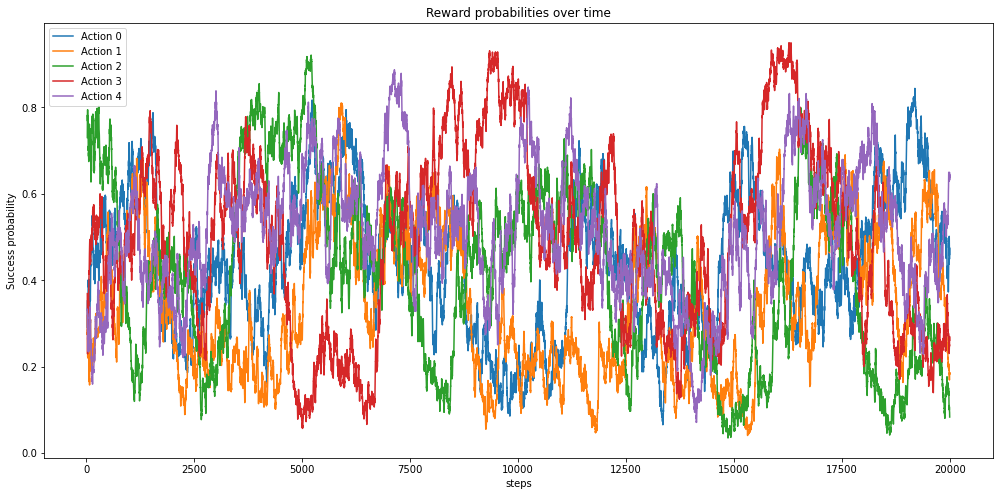

In [10]:
import pandas

drifting_env = DriftingBandit(n_actions=5)

drifting_probs = []
for i in range(20000):
    drifting_env.step()
    drifting_probs.append(drifting_env._probs)

plt.figure(figsize=(17, 8))
plt.plot(pandas.DataFrame(drifting_probs).rolling(window=20).mean())

plt.xlabel("steps")
plt.ylabel("Success probability")
plt.title("Reward probabilities over time")
plt.legend(["Action {}".format(i) for i in range(drifting_env.action_count)])
plt.show()

对于会变的`bandit`，各个智能体的表现情况为:

/var/folders/x9/xgj8n5xd2bb0cv55w7c72bn40000gn/T/ipykernel_31594/884386608.py:10: RuntimeWarning: invalid value encountered in true_divide
  return np.argmax(self._successes / (self._successes + self._failures) )
/var/folders/x9/xgj8n5xd2bb0cv55w7c72bn40000gn/T/ipykernel_31594/2254239578.py:6: RuntimeWarning: invalid value encountered in true_divide
  weights = (self._successes/(self._successes + self._failures)) + np.sqrt(2 * np.log(self._total_pulls) / (self._successes + self._failures) )
/var/folders/x9/xgj8n5xd2bb0cv55w7c72bn40000gn/T/ipykernel_31594/2254239578.py:6: RuntimeWarning: divide by zero encountered in log
  weights = (self._successes/(self._successes + self._failures)) + np.sqrt(2 * np.log(self._total_pulls) / (self._successes + self._failures) )
/var/folders/x9/xgj8n5xd2bb0cv55w7c72bn40000gn/T/ipykernel_31594/2254239578.py:6: RuntimeWarning: invalid value encountered in sqrt
  weights = (self._successes/(self._successes + self._failures)) + np.sqrt(2 * np.log(self._tota

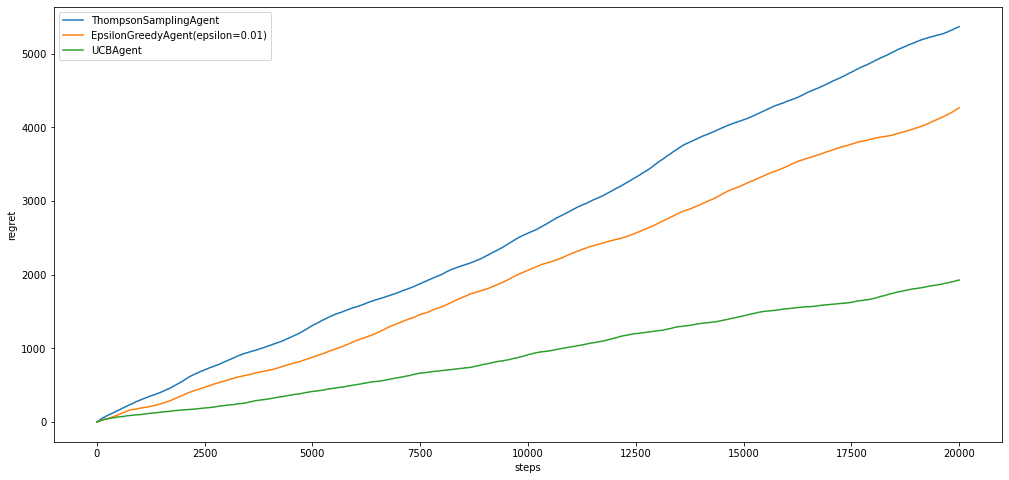

In [13]:
drifting_agents = [
    ThompsonSamplingAgent(),
    EpsilonGreedyAgent(),
    UCBAgent(),
]
    
plot_regret(DriftingBandit(), drifting_agents, n_steps=20000, n_trials=10)